In [ ]:
!pip install -q --upgrade ultralytics kaggle pycocotools pandas matplotlib seaborn tqdm


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os, json, random, shutil, zipfile, itertools, math, collections, pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ultralytics import YOLO
from datetime import datetime
%matplotlib inline

In [ ]:
DATA_DIR = Path('data/coco2017')
DATA_DIR.mkdir(parents=True, exist_ok=True)

## 1 Формирование подмножества (≈ 20 %)
Создадим отдельную папку `coco2017_subset` и перенесём туда случайные 20 % изображений и соответствующие аннотации. Размер поднабора ≈4‑5 GB, что существенно ускорит обучение.

In [10]:
import json, random, shutil
from pathlib import Path
from tqdm import tqdm

DATA_DIR = Path('data/coco2017')
SUBSET_RATIO = 0.22
SUBSET_DIR = DATA_DIR/'coco2017_subset'
SUBSET_DIR.mkdir(parents=True, exist_ok=True)

def build_subset(split):
    img_dir = DATA_DIR/f'{split}2017'  # исправлено: без папки images/
    ann_file = DATA_DIR/'annotations'/f'instances_{split}2017.json'

    out_img_dir = SUBSET_DIR/f'{split}2017'  # без папки images/
    out_ann_dir = SUBSET_DIR/'annotations'
    out_img_dir.mkdir(parents=True, exist_ok=True)
    out_ann_dir.mkdir(parents=True, exist_ok=True)

    with open(ann_file) as f:
        ann = json.load(f)

    imgs = ann['images']
    selected_imgs = random.sample(imgs, int(len(imgs) * SUBSET_RATIO))
    selected_img_ids = {img['id'] for img in selected_imgs}

    # Копируем изображения
    for img in tqdm(selected_imgs, desc=f'Копируем {split} изображения'):
        src = img_dir / img['file_name']
        dst = out_img_dir / img['file_name']
        if src.exists():
            shutil.copy(src, dst)

    # Фильтруем аннотации
    selected_annotations = [a for a in ann['annotations'] if a['image_id'] in selected_img_ids]
    ann_subset = {
        'images': selected_imgs,
        'annotations': selected_annotations,
        'categories': ann['categories']
    }
    with open(out_ann_dir/f'instances_{split}2017.json', 'w') as f:
        json.dump(ann_subset, f)

for s in ['train', 'val']:
    build_subset(s)

print('Подмножество готово:', SUBSET_DIR)


Копируем val изображения: 100%|██████████| 1100/1100 [00:19<00:00, 55.89it/s]


Подмножество готово: data\coco2017\coco2017_subset


## 2. Базовый анализ датасета
В аутпуте наблюдаем, что:
1. средний размер (mean) изображений составляет около 578x484
2. стандартное отклонение (std): 92x98
3. минимальное разрешение: 119x102
4. 25% изображений имеют ширину меньше 500 и высоту меньше 426
5. Половина изображений меньше или равна 640×480 пикселей
6. 75% изображений меньше или равны 640×514
7. Самое большое изображение — 640×640 пикселей

In [11]:
from collections import Counter
ann_path = SUBSET_DIR/'annotations/instances_train2017.json'
with open(ann_path) as f:
    data_ann = json.load(f)

# Категории
categories = {c['id']: c['name'] for c in data_ann['categories']}
print(f'Всего классов: {len(categories)}')
print('Список классов:', list(categories.values()))

# Общее количество изображений
num_images = len(data_ann['images'])
print('Изображений в подмножестве (train):', num_images)

# Разрешения
resolutions = [(img['width'], img['height']) for img in data_ann['images']]
res_df = pd.DataFrame(resolutions, columns=['width', 'height'])
print(res_df.describe())

Всего классов: 80
Список классов: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
Изображений в подмножестве (train): 26023
              width        height
count  26023.000000  26023.0

На визуализации наблюдаем жесткий дисбаланс классов.
Класс "person" доминирует.
Модель будет склонна предсказывать "person" чаще, чем нужно. Это приведет к низкому recall для редких классов.
Классы справа (типа "parking meter", "hair drier") имеют очень мало примеров.

#### Идеи для борьбы:
1. использовать Class-weighted loss (если бы юзали pytorch) или Focal Loss. Тем самым повысим веса редких классов
2. насытить редкие классы аугментацией
3. использовать Weighted Dataloader (https://y-t-g.github.io/tutorials/yolo-class-balancing/)

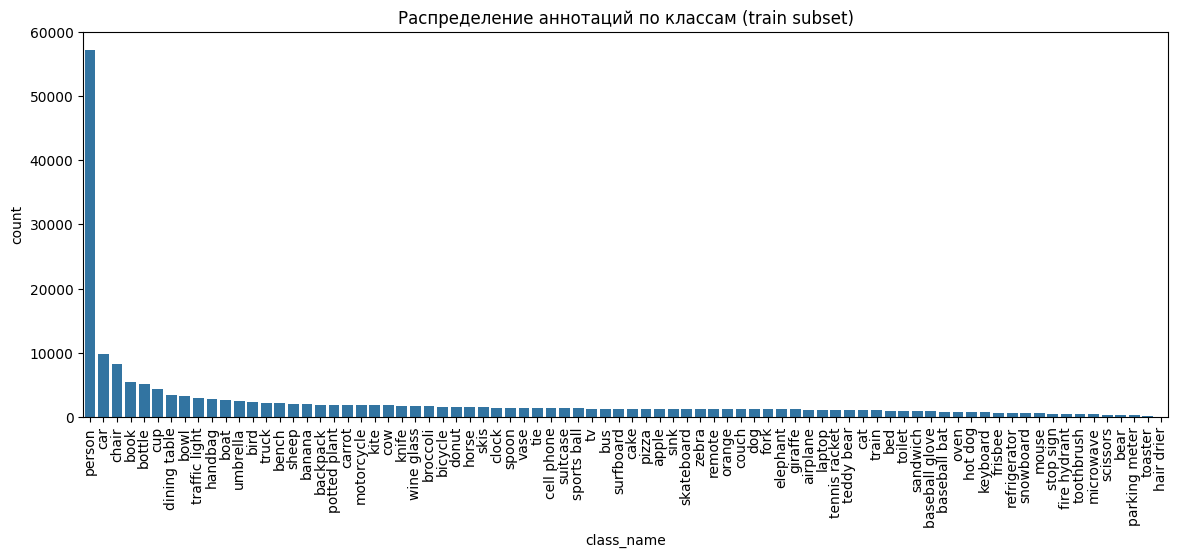

In [12]:
# Распределение по классам
cls_counts = Counter([a['category_id'] for a in data_ann['annotations']])
cls_df = pd.DataFrame({'class_id': list(cls_counts.keys()),
                       'count': list(cls_counts.values())})
cls_df['class_name'] = cls_df['class_id'].map(categories)
cls_df = cls_df.sort_values('count', ascending=False)

plt.figure(figsize=(14,5))
sns.barplot(data=cls_df, x='class_name', y='count')
plt.xticks(rotation=90)
plt.title('Распределение аннотаций по классам (train subset)')
plt.show()

## 3. Анализ размеров bounding box‑ов
На визуализации наблюдаем, что много мелких объектов. Также есть большие bbox-ы с шириной 640 пикселей.

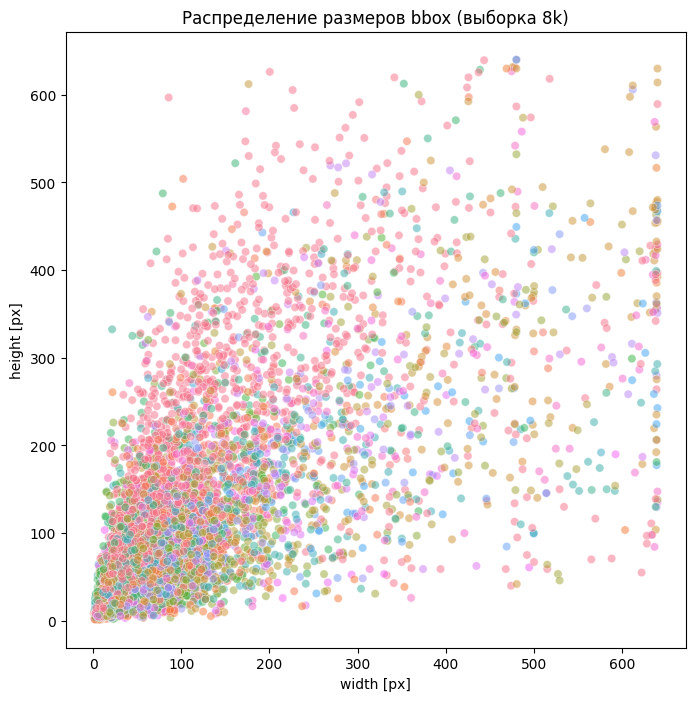

In [13]:
# Создание DataFrame с размерами bbox
bbox_data = []
for a in data_ann['annotations']:
    x, y, w, h = a['bbox']
    bbox_data.append({'class_id': a['category_id'], 'width': w, 'height': h})
bbox_df = pd.DataFrame(bbox_data)
bbox_df['class_name'] = bbox_df['class_id'].map(categories)

# График распределения
plt.figure(figsize=(8,8))
sns.scatterplot(data=bbox_df.sample(8000), x='width', y='height', hue='class_name', alpha=0.5, legend=False)
plt.title('Распределение размеров bbox (выборка 8k)')
plt.xlabel('width [px]')
plt.ylabel('height [px]')
plt.show()

## 4. Подготовка `data.yaml` для Ultralytics YOLO

In [19]:
from ultralytics.data.converter import convert_coco

convert_coco(
    labels_dir=r"D:\VS_Projects\y11\data\coco2017\coco2017_subset\annotations",
    save_dir=r"D:\VS_Projects\y11\data\coco2017\coco2017_subset",
    use_segments=False,   # только bbox
    use_keypoints=False,
    cls91to80=True
)


Annotations D:\VS_Projects\y11\data\coco2017\coco2017_subset\annotations\instances_train2017.json: 100%|██████████| 25792/25792 [00:09<00:00, 2658.45it/s]
Annotations D:\VS_Projects\y11\data\coco2017\coco2017_subset\annotations\instances_val2017.json: 100%|██████████| 1093/1093 [00:00<00:00, 3324.43it/s]

COCO data converted successfully.
Results saved to D:\VS_Projects\y11\data\coco2017\coco2017_subset2


## 5. Обучение YOLO11
Делаем файнтьюн на готовой претрейн модели **`yolo11n.pt`**

In [4]:
model = YOLO('yolo11n.pt')      # или 'yolo11s.pt' для лучшего качества
model.train(data=r"D:\VS_Projects\y11\data\coco2017\coco2017_subset\coco_subset.yaml",
            epochs=50,
            imgsz=640,
            batch=16,
            lr0=0.0001,         # 1e-4
            optimizer='AdamW',
            device=0,
            
            cls=1.0,            # Увеличиваем вес cls loss (default 0.5)
            
            # Аугментации
            hsv_h=0.015,
            hsv_s=0.7, 
            hsv_v=0.4,
            translate=0.1,
            scale=0.9,
            flipud=0.0,
            fliplr=0.5,
            mosaic=1.0,
            mixup=0.2,
            copy_paste=0.1,
            close_mosaic=10,

            patience=15,

            project='runs',
            name='yolo11_coco_subset',
            pretrained=True)

New https://pypi.org/project/ultralytics/8.3.153 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.152  Python-3.11.9 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\VS_Projects\y11\data\coco2017\coco2017_subset\coco_subset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yol

train: Scanning D:\VS_Projects\y11\data\coco2017\coco2017_subset\train\labels.cache... 25792 images, 231 backgrounds, 0 corrupt: 100%|██████████| 26023/26023 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 3.22.5 MB/s, size: 138.0 KB)


val: Scanning D:\VS_Projects\y11\data\coco2017\coco2017_subset\valid\labels.cache... 1093 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1100/1100 [00:00<?, ?it/s]


Plotting labels to runs\yolo11_coco_subset3\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\yolo11_coco_subset3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.19G      1.458      3.822      1.372        108        640: 100%|██████████| 1627/1627 [05:21<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  3.92it/s]


                   all       1100       7916      0.509      0.324      0.344      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.19G      1.403      3.531      1.333        102        640: 100%|██████████| 1627/1627 [04:55<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]


                   all       1100       7916      0.579      0.434      0.475      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       4.2G      1.381      3.423      1.318        107        640: 100%|██████████| 1627/1627 [04:47<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


                   all       1100       7916      0.629      0.454      0.507      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       4.2G      1.375      3.375      1.313         97        640: 100%|██████████| 1627/1627 [04:36<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


                   all       1100       7916      0.618      0.464       0.51      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       4.2G      1.367      3.341      1.313         79        640: 100%|██████████| 1627/1627 [04:35<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


                   all       1100       7916      0.599      0.458      0.502      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       4.2G      1.371      3.335       1.31        124        640: 100%|██████████| 1627/1627 [04:44<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


                   all       1100       7916      0.607      0.468      0.511      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       4.2G      1.369      3.319      1.309         87        640: 100%|██████████| 1627/1627 [04:43<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]


                   all       1100       7916      0.626      0.463      0.512      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       4.2G      1.367      3.309      1.305        110        640: 100%|██████████| 1627/1627 [04:41<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


                   all       1100       7916      0.631      0.468      0.514      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       4.2G      1.362      3.293      1.306         89        640: 100%|██████████| 1627/1627 [05:47<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


                   all       1100       7916      0.594       0.48      0.518      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       4.2G      1.359      3.269      1.302         72        640: 100%|██████████| 1627/1627 [04:42<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.39it/s]


                   all       1100       7916      0.617       0.47      0.518      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       4.2G      1.356      3.259      1.304        147        640: 100%|██████████| 1627/1627 [04:42<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


                   all       1100       7916      0.615      0.485      0.521      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       4.2G       1.35      3.236        1.3        104        640: 100%|██████████| 1627/1627 [04:41<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.43it/s]


                   all       1100       7916      0.641      0.466      0.517       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       4.2G      1.354      3.224      1.298        131        640: 100%|██████████| 1627/1627 [04:42<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.53it/s]


                   all       1100       7916      0.638      0.465      0.521      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       4.2G      1.356       3.23      1.299         92        640: 100%|██████████| 1627/1627 [04:37<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


                   all       1100       7916      0.612       0.49      0.527      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       4.2G      1.351      3.207      1.296         67        640: 100%|██████████| 1627/1627 [04:37<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


                   all       1100       7916      0.605      0.479      0.524      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       4.2G      1.347      3.203      1.295        175        640: 100%|██████████| 1627/1627 [04:36<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.49it/s]


                   all       1100       7916      0.625      0.484       0.53      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       4.2G      1.345      3.189      1.294        142        640: 100%|██████████| 1627/1627 [04:36<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


                   all       1100       7916      0.612      0.495      0.533      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       4.2G      1.343      3.189      1.292        111        640: 100%|██████████| 1627/1627 [04:34<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


                   all       1100       7916      0.634      0.483      0.531       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       4.2G      1.342      3.158      1.291         88        640: 100%|██████████| 1627/1627 [04:33<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


                   all       1100       7916      0.633      0.485      0.529      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       4.2G      1.341      3.166      1.291        129        640: 100%|██████████| 1627/1627 [04:34<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


                   all       1100       7916       0.61       0.49      0.531       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       4.2G      1.342      3.163       1.29        154        640: 100%|██████████| 1627/1627 [04:32<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


                   all       1100       7916      0.647      0.475       0.53      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       4.2G      1.343      3.146      1.291        110        640: 100%|██████████| 1627/1627 [04:36<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


                   all       1100       7916       0.63      0.485      0.529      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       4.2G      1.331       3.13      1.284        108        640: 100%|██████████| 1627/1627 [04:36<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  4.31it/s]


                   all       1100       7916       0.63      0.484       0.53      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       4.2G      1.333      3.123      1.285        148        640: 100%|██████████| 1627/1627 [04:35<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


                   all       1100       7916      0.636       0.48      0.535      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       4.2G      1.332      3.114      1.286        150        640: 100%|██████████| 1627/1627 [04:36<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.23it/s]


                   all       1100       7916       0.65      0.479      0.535      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       4.2G      1.331      3.098      1.281        216        640: 100%|██████████| 1627/1627 [04:21<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.10it/s]


                   all       1100       7916      0.644       0.48      0.535      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       4.2G      1.328      3.098       1.28        126        640: 100%|██████████| 1627/1627 [04:24<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


                   all       1100       7916      0.631      0.483      0.534      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       4.2G      1.331      3.086      1.278        165        640: 100%|██████████| 1627/1627 [04:22<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.02it/s]


                   all       1100       7916      0.654      0.478      0.535      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       4.5G      1.326      3.075      1.278         69        640: 100%|██████████| 1627/1627 [04:24<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


                   all       1100       7916      0.656      0.477      0.535      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       4.5G      1.327      3.075      1.277        124        640: 100%|██████████| 1627/1627 [04:24<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.02it/s]


                   all       1100       7916      0.659      0.477      0.535      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       4.5G      1.319      3.047      1.274        106        640: 100%|██████████| 1627/1627 [04:22<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


                   all       1100       7916       0.65      0.478      0.535      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       4.5G      1.325      3.062      1.277        120        640: 100%|██████████| 1627/1627 [04:24<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


                   all       1100       7916      0.646       0.48      0.535      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.51G      1.319      3.039      1.273        127        640: 100%|██████████| 1627/1627 [04:25<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.06it/s]


                   all       1100       7916      0.652       0.48      0.536      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.51G      1.317      3.032      1.273         75        640: 100%|██████████| 1627/1627 [04:23<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.92it/s]


                   all       1100       7916       0.64      0.485      0.537      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.51G      1.313      3.023      1.272        123        640: 100%|██████████| 1627/1627 [04:24<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


                   all       1100       7916      0.635      0.484      0.537      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.51G      1.316      3.022      1.272        148        640: 100%|██████████| 1627/1627 [04:25<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


                   all       1100       7916      0.638      0.486      0.538      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.51G      1.314      3.002      1.269        157        640: 100%|██████████| 1627/1627 [04:23<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  5.00it/s]


                   all       1100       7916      0.644      0.484      0.539      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.51G      1.311      2.999       1.27         63        640: 100%|██████████| 1627/1627 [04:25<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.01it/s]


                   all       1100       7916      0.647      0.485      0.539      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.83G      1.313      2.992      1.269         99        640: 100%|██████████| 1627/1627 [04:24<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


                   all       1100       7916      0.646      0.485      0.538      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.83G      1.309      2.997      1.265         85        640: 100%|██████████| 1627/1627 [04:23<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.00it/s]


                   all       1100       7916      0.645      0.488      0.538      0.376
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.83G       1.16      2.437      1.205         32        640: 100%|██████████| 1627/1627 [04:04<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.33it/s]


                   all       1100       7916      0.643      0.487      0.538      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.83G      1.148      2.381        1.2         67        640: 100%|██████████| 1627/1627 [04:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.33it/s]


                   all       1100       7916      0.648      0.485      0.538      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.83G      1.146      2.356      1.197         26        640: 100%|██████████| 1627/1627 [04:05<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.26it/s]


                   all       1100       7916      0.652      0.484      0.539      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.83G      1.148      2.339      1.197         54        640: 100%|██████████| 1627/1627 [04:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.27it/s]


                   all       1100       7916       0.66      0.481      0.539      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.83G      1.138      2.325      1.192         34        640: 100%|██████████| 1627/1627 [04:07<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.19it/s]


                   all       1100       7916      0.656      0.483      0.538      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.83G      1.135      2.309       1.19         25        640: 100%|██████████| 1627/1627 [04:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


                   all       1100       7916      0.658      0.483      0.539      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.83G      1.134      2.297      1.188         37        640: 100%|██████████| 1627/1627 [04:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.23it/s]


                   all       1100       7916      0.662      0.479      0.538      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.83G      1.132      2.296       1.19         46        640: 100%|██████████| 1627/1627 [04:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


                   all       1100       7916      0.662      0.478      0.538      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.83G      1.131      2.273      1.188         42        640: 100%|██████████| 1627/1627 [04:07<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.21it/s]


                   all       1100       7916      0.655      0.481      0.538      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.83G      1.131      2.276      1.187         43        640: 100%|██████████| 1627/1627 [04:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.26it/s]


                   all       1100       7916      0.662      0.479      0.539      0.376

50 epochs completed in 3.869 hours.
Optimizer stripped from runs\yolo11_coco_subset3\weights\last.pt, 5.5MB
Optimizer stripped from runs\yolo11_coco_subset3\weights\best.pt, 5.5MB

Validating runs\yolo11_coco_subset3\weights\best.pt...
Ultralytics 8.3.152  Python-3.11.9 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.44it/s]


                   all       1100       7916      0.642      0.487      0.538      0.376
                person        610       2494      0.764      0.645      0.728      0.491
               bicycle         40         98      0.717      0.459      0.561      0.326
                   car        120        411      0.626       0.52      0.575      0.378
            motorcycle         36         79      0.715      0.608      0.685      0.416
              airplane         21         27      0.759      0.815      0.841      0.633
                   bus         45         71      0.837      0.718       0.75      0.604
                 train         29         33      0.799      0.788      0.835      0.646
                 truck         59        101      0.559      0.376      0.482      0.306
                  boat         18         44      0.519      0.386      0.427      0.277
         traffic light         53        160      0.756       0.29      0.405      0.202
          fire hydran

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78,
       79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DB7D043E50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024

In [5]:
model = YOLO(r"D:\VS_Projects\y11\runs\yolo11_coco_subset3\weights\best.pt")
res = model.val(data=r"D:\VS_Projects\y11\data\coco2017\coco2017_subset\coco_subset.yaml", split='val')

Ultralytics 8.3.152  Python-3.11.9 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1201.1340.2 MB/s, size: 133.3 KB)


val: Scanning D:\VS_Projects\y11\data\coco2017\coco2017_subset\valid\labels.cache... 1093 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1100/1100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:10<00:00,  6.65it/s]


                   all       1100       7916      0.651      0.485      0.539      0.377
                person        610       2494      0.771      0.638      0.728      0.491
               bicycle         40         98       0.74      0.469      0.556       0.32
                   car        120        411      0.645      0.513      0.577       0.38
            motorcycle         36         79      0.751      0.611      0.689      0.417
              airplane         21         27      0.757       0.81      0.842      0.623
                   bus         45         71      0.835      0.704      0.739      0.598
                 train         29         33      0.799      0.758      0.823      0.637
                 truck         59        101       0.54      0.356      0.469      0.298
                  boat         18         44      0.557      0.386      0.445      0.282
         traffic light         53        160      0.749      0.281      0.399      0.204
          fire hydran

In [10]:
df = (pd.DataFrame(res.summary())
        .rename(columns={"box-map": "mAP50-95",
                         "box-p"  : "precision",
                         "box-r"  : "recall",
                         "box-f1" : "F1"})
        .set_index("class_name"))

# Собираем по 3 худших класса для каждой метрики
metrics = ["precision", "recall", "F1", "mAP50-95"]
worst_by_metric = {}

for m in metrics:
    worst_by_metric[m] = df.sort_values(m).head(3)
    print(f"\n=== Худшие 3 класса по {m} ===")
    print(worst_by_metric[m][metrics].to_string(float_format="%.4f"))


=== Худшие 3 класса по precision ===
            precision  recall     F1  mAP50-95
class_name                                    
hair drier     0.1122  0.0909 0.1004    0.3767
apple          0.2291  0.1892 0.2072    0.3767
knife          0.2849  0.1053 0.1537    0.3767

=== Худшие 3 класса по recall ===
              precision  recall     F1  mAP50-95
class_name                                      
teddy bear       1.0000  0.0000 0.0000    0.3767
hair drier       0.1122  0.0909 0.1004    0.3767
refrigerator     0.5811  0.0923 0.1593    0.3767

=== Худшие 3 класса по F1 ===
            precision  recall     F1  mAP50-95
class_name                                    
teddy bear     1.0000  0.0000 0.0000    0.3767
hair drier     0.1122  0.0909 0.1004    0.3767
knife          0.2849  0.1053 0.1537    0.3767

=== Худшие 3 класса по mAP50-95 ===
            precision  recall     F1  mAP50-95
class_name                                    
person         0.7713  0.6379 0.6983    0.3767
bic

## 6. Корреляция (confusion) между классами

Как и предполагали: модель учиться в первую очередь на классе 'person'.

Заметим, что 'background' часто путается с 'person'. Скорее всего модель реагирует на «силуэты», тени и т. п.

Видны ошибки между классами 'fork', 'spoon' и 'knife'. Модель плохо различает мелкие кухонные предметы.

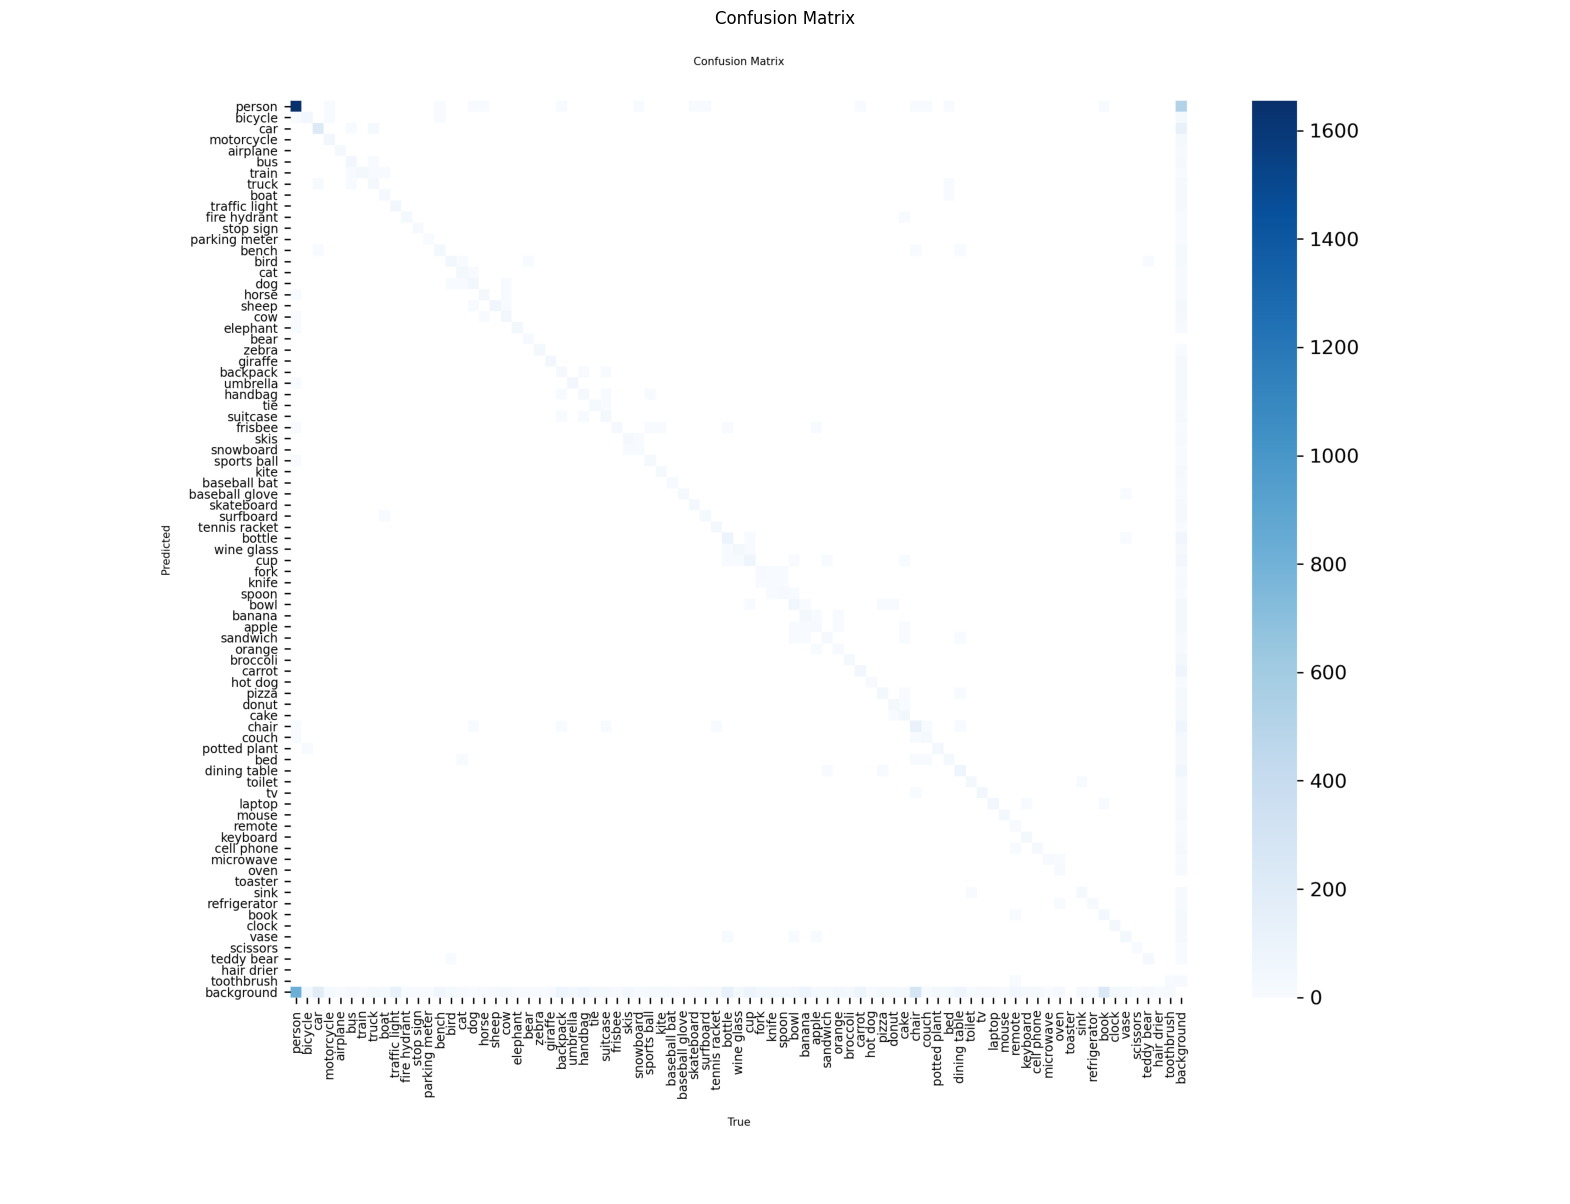

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('runs/yolo11_coco_subset3/confusion_matrix.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()

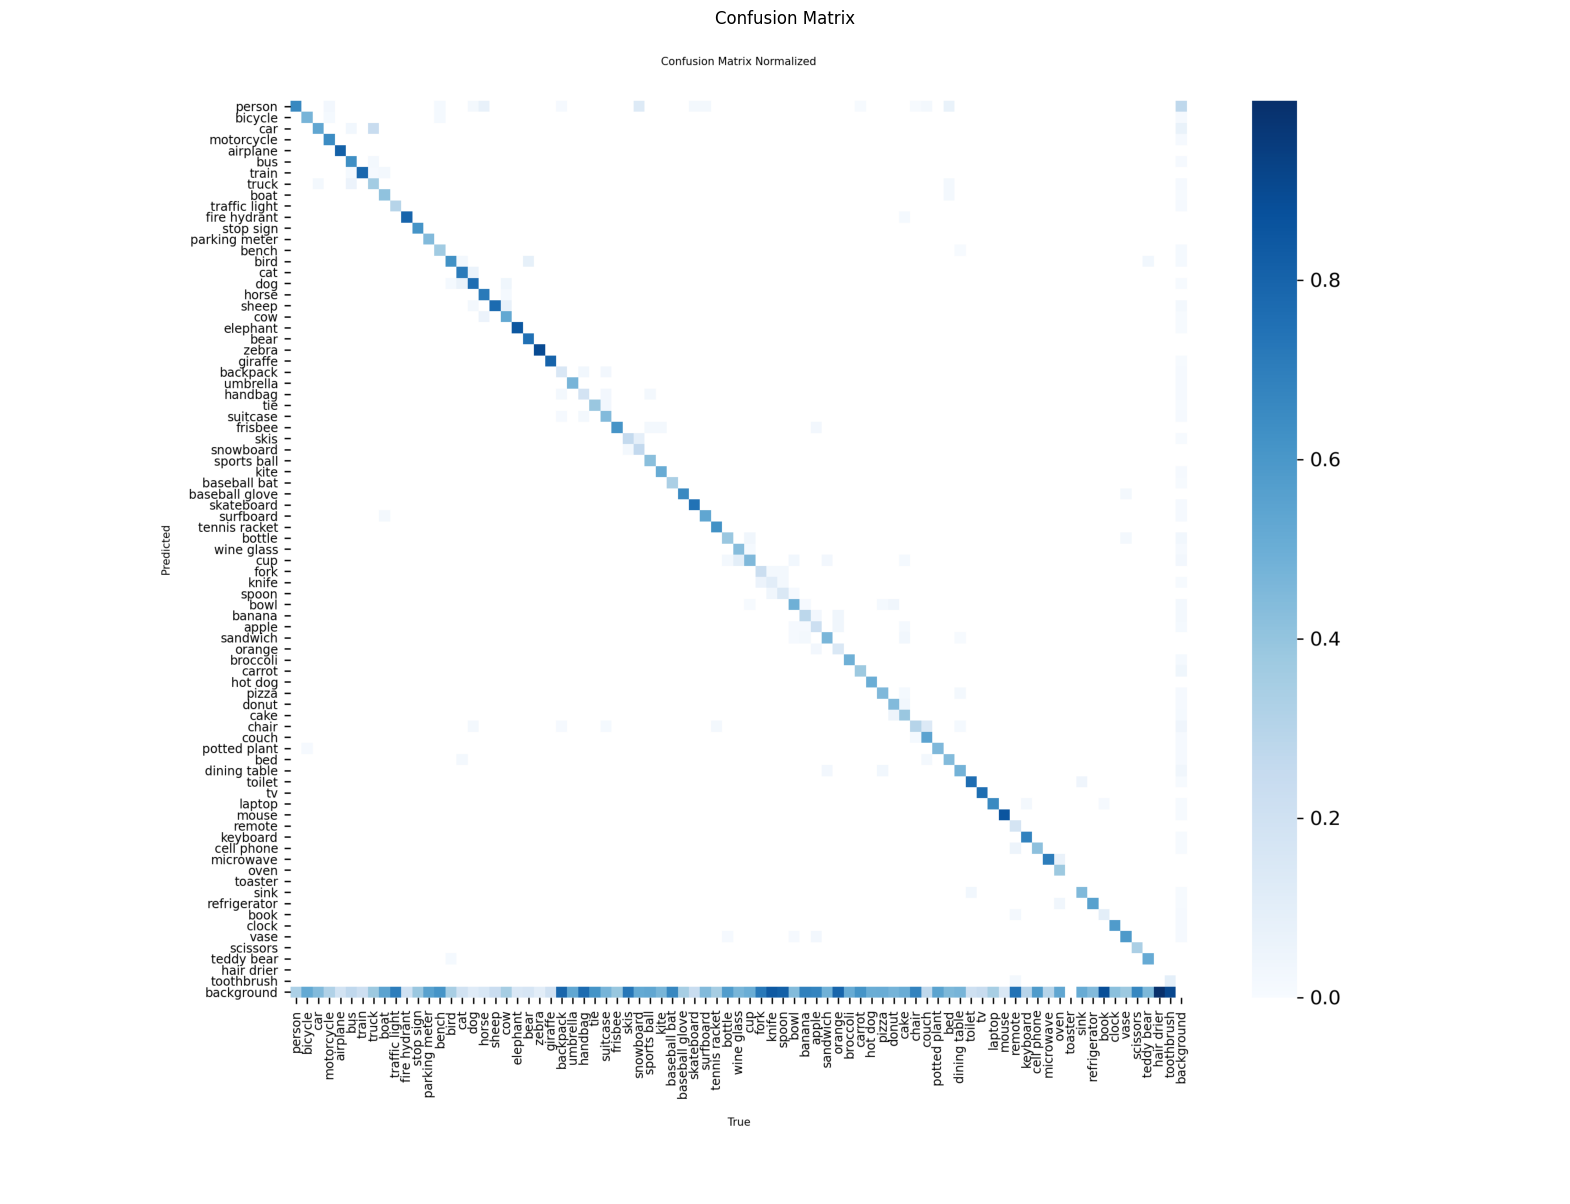

In [20]:
img = mpimg.imread('runs/yolo11_coco_subset3/confusion_matrix_normalized.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()

### 6.1 Анализ причин высокой корреляции
Ниже приведены примеры трёх пар классов с наибольшей взаимной путаницей и потенциальные причины:
1. **`knife и fork`** – близкие формы, часто присутствуют одновременно на изображениях столовых приборов.
2. **`dog и cat`** – похожая размерная категория животных, при мелком масштабе детали теряются.
3. **`skateboard и surfboard`** – вытянутая форма, схожие текстуры дерева/пластика.

**Методы улучшения:**
- Увеличить выборку изображений с этими классами (Data Augmentation, oversampling).
- Добавить CutMix/Mosaic для большего разнообразия контекстов.
- Использовать больший backbone (yolo11m/l) или увеличить `imgsz`.
- Применить **class‑balanced loss** или **focal loss** для акцентирования на редких/сложно‑различимых классах.

## F1
Пиковое значение F1 = 0.53 достигается при пороге confid. = 0.27. При 27% уверенности баланс “точность-полнота” для всей выборки самый высокий. Это и есть «рекомендованный» порог для инференса.

Формы и максимумы отдельных классов сильно отличаются, что опять говорит о дисбалансе классов

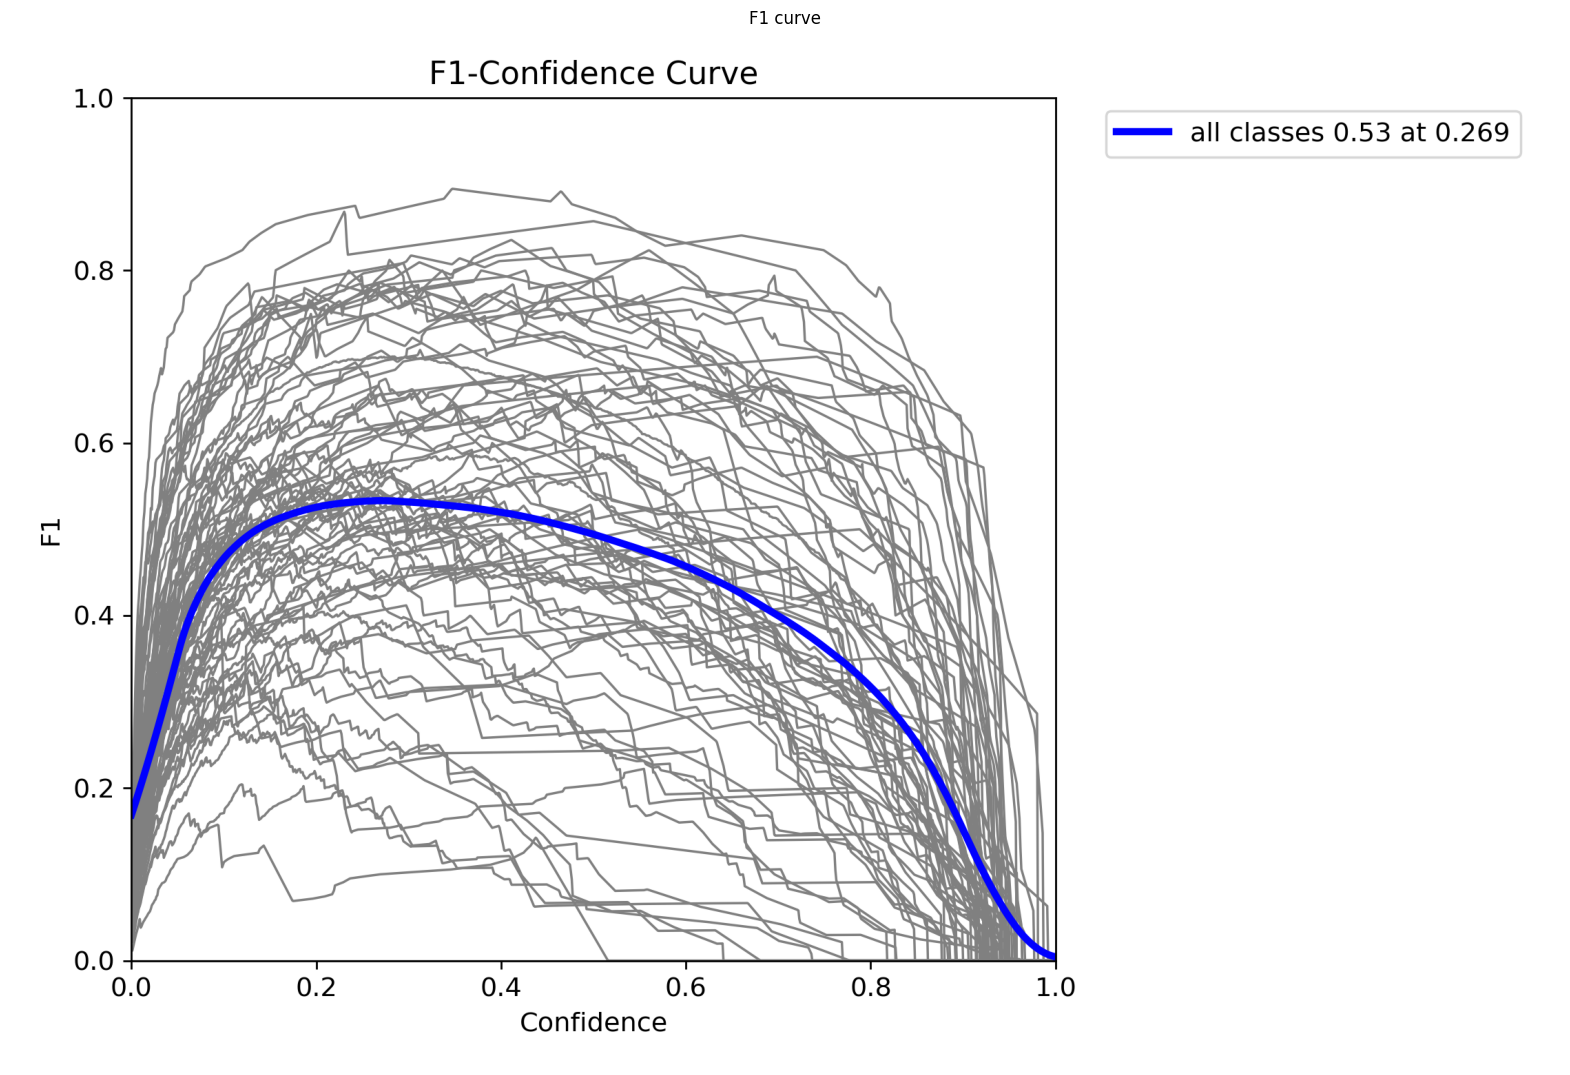

In [24]:
img = mpimg.imread('runs/yolo11_coco_subset3/F1_curve.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.title('F1 curve')
plt.show()

## Precision & Recall
- PR_Curve. Точность и полнота уравновешены. Доминации нет
- R_Curve. R = 0.76 при conf = 0.0, затем монотонное падение до 0
- P_Curve. Модель «увереннее» в правильных детекциях: высокие confidences в основном истинны. Для задач, где FP критичны, можно смело ставить conf >= 0.6 и получить точность > 0.9, но recall упадёт до 0.25

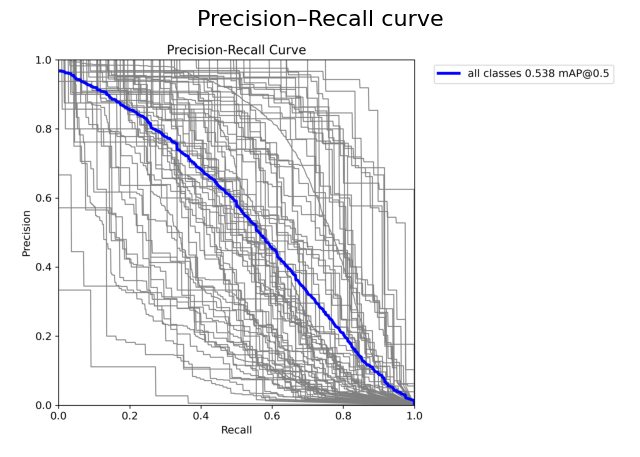

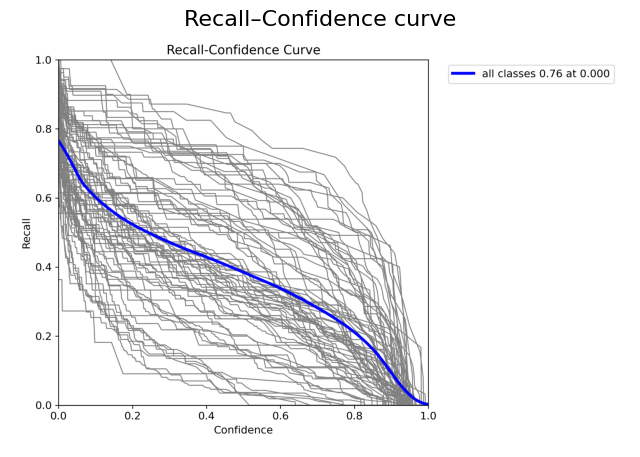

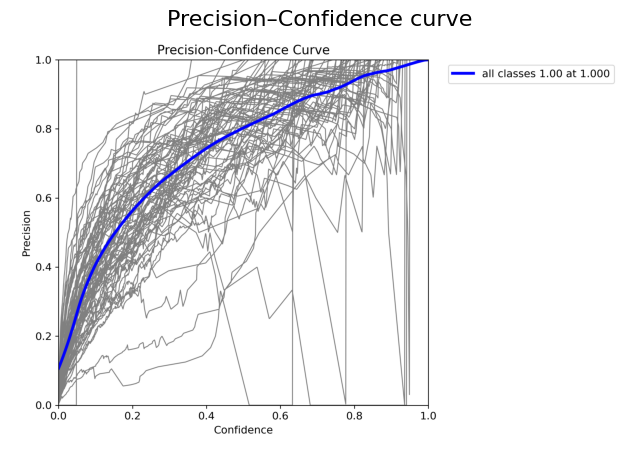

In [29]:
paths = [
    'runs/yolo11_coco_subset3/PR_curve.png',     # Precision–Recall
    'runs/yolo11_coco_subset3/R_curve.png',      # Recall–Confidence
    'runs/yolo11_coco_subset3/P_curve.png'       # Precision–Confidence
]
titles = [
    'Precision–Recall curve',
    'Recall–Confidence curve',
    'Precision–Confidence curve'
]

for path, title in zip(paths, titles):
    img = mpimg.imread(path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()


## train/val results
- train/box_loss, cls_loss, dfl_loss. По графикам похоже, что использовался Cosine LR, хотя его не включали и по дефолту он 'false'.
- val/box_loss, val/cls_loss, val/dfl_loss. Переобучения нет, модель обобщает стабильно.
- metrics/precision(B). Точность улучшается даже после снижения LR.
- metrics/recall(B). Сеть уже почти «выжала» максимум из данных.
- metrics/mAP50(B) и mAP50-95(B). Достигнута точка насыщения; мАп уже близок к потолку nano-архитектуры на COCO.

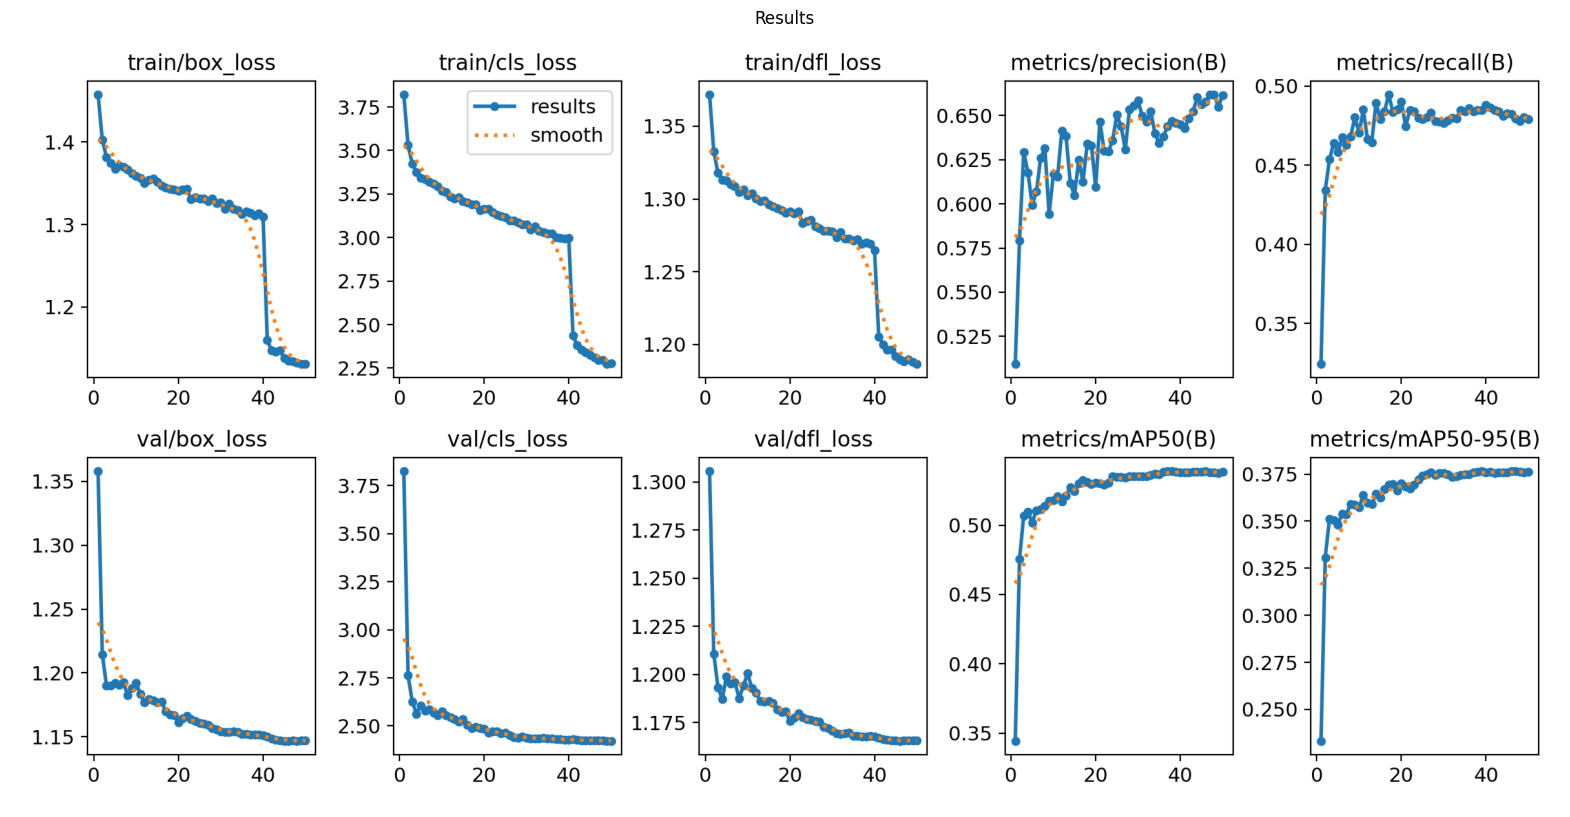

In [30]:
img = mpimg.imread('runs/yolo11_coco_subset3/results.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.title('Results')
plt.show()

## 8. Выводы
- Итоговое качество модели зависит от количества данных — при 50 эпохах и объёме 22 % COCO‑2017 достигается mAP = 0.37.
- Наиболее «проблемные» классы требуют дополнительных данных и целевой тонкой настройки.

tg: @yoursAnthony